<a href="https://colab.research.google.com/github/jkrue242/PortfolioOptimization/blob/main/portfolio_optimiztion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Portfolio Optimization using Deep Learning

#### Implementation and modification of [this paper](https://arxiv.org/pdf/2005.13665).

#### Modifications will include:
1. Use of different recursive networks (Transformer, GRU, LSTM)
2. Hyperparameter optimization
3. Additional input features
4. Loss function comparison between Sharpe and Sortino

Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [131]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In our analysis, we will build a simple portfolio of 4 indices:
1. AGG (Agg. Bond ETF)
2. DBC (Commodity Index)
3. VTI (Vanguard Total Stock Index)
4. VIX (CBOE Volatility Index)

In [104]:
# constants for dataset and training stuff
ETFS = ["VOO","QQQ","GLD"]
N_TICKERS = len(ETFS)

SAMPLE_DAYS = 50
ROLLING_AVGS = [10, 30, 50]
BATCH_SIZE = 64
START_DATE = '2010-01-01'
END_DATE ='2025-01-01'

# try to use cuda for training
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running notebook on {DEVICE}")

Running notebook on cuda


Pull data from yfinance. Features used:
1. Close Price
2. Returns (% change of close)
3. 10-day, 30-day, 50-day Rolling Averages

In [133]:
ticker_df = yf.download(ETFS, start=START_DATE, end=END_DATE, group_by='ticker', auto_adjust=True)
features = []
for e in ETFS:
  data = ticker_df[e].copy()

  # returns features
  data['return'] = data['Close'].pct_change().fillna(0)
  data['cumulative_return'] = (1 + data['return']).cumprod() - 1

  # rolling average feature
  for i in ROLLING_AVGS:
    data[f"ma_{i}"] = data['Close'].rolling(i).mean().fillna(method='bfill')

  # build up feature list
  features.append(data[['return'] + ['cumulative_return'] + [f"ma_{i}" for i in ROLLING_AVGS]])

data = pd.concat(features, axis=1, keys=ETFS).dropna()
N_FEATURES = len(data.columns)//N_TICKERS

[*********************100%***********************]  3 of 3 completed


In [134]:
print(f"Number of features: {N_FEATURES}")

Number of features: 5


In [135]:
data.tail()

VOO                                                        \
Price         return cumulative_return       ma_10       ma_30       ma_50   
Date                                                                         
2024-12-24  0.010289          6.112845  547.312677  546.749703  540.711288   
2024-12-26 -0.000018          6.112715  546.920239  546.942729  541.140410   
2024-12-27 -0.010365          6.038991  546.242871  546.936141  541.410826   
2024-12-30 -0.011132          5.960633  544.962579  546.842818  541.558273   
2024-12-31 -0.004030          5.932585  543.248492  546.910189  541.621344   

                 QQQ                                                        \
Price         return cumulative_return       ma_10       ma_30       ma_50   
Date                                                                         
2024-12-24  0.013560         12.070525  524.844501  514.741699  506.698452   
2024-12-26 -0.000679         12.061646  524.897736  515.324689  507.488078   
2024-12-27 -0.013293         11.888016  524.588953  515.695291  508.135917   
2024-12-30 -0.013300         11.716607  523.184454  515.952872  508.638185   
2024-12-31 -0.008495         11.608583  520.580978  516.467419  508.988784   

                 GLD                                                      
Price         return cumulative_return       ma_10       ma_30     ma_50  
Date                                                                      
2024-12-24  0.001992          1.198907  243.471002  243.258666  246.3490  
2024-12-26  0.006751          1.213752  242.682002  243.359333  246.2920  
2024-12-27 -0.006871          1.198543  242.094002  243.485000  246.1770  
2024-12-30 -0.003190          1.191530  241.728003  243.605667  246.0170  
2024-12-31  0.006234          1.205191  241.453003  243.790334  245.8342

Plot all the features

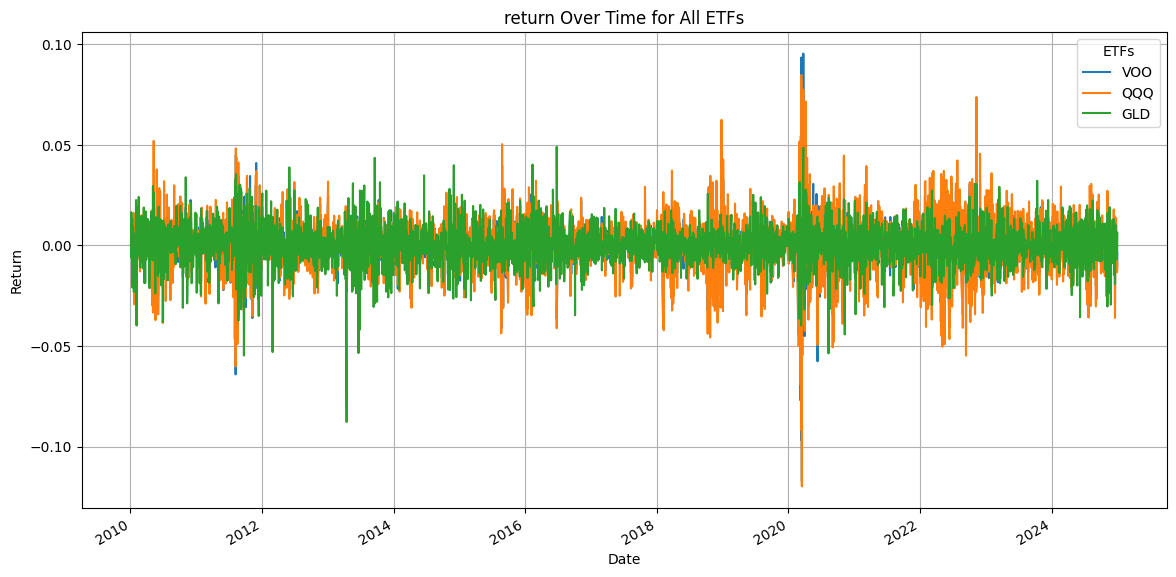

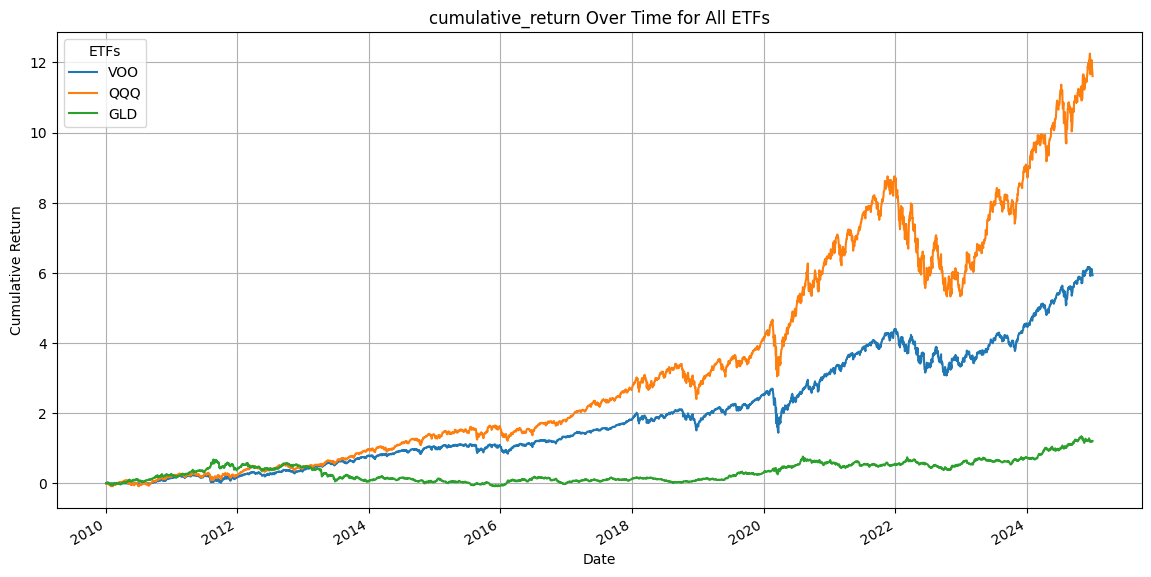

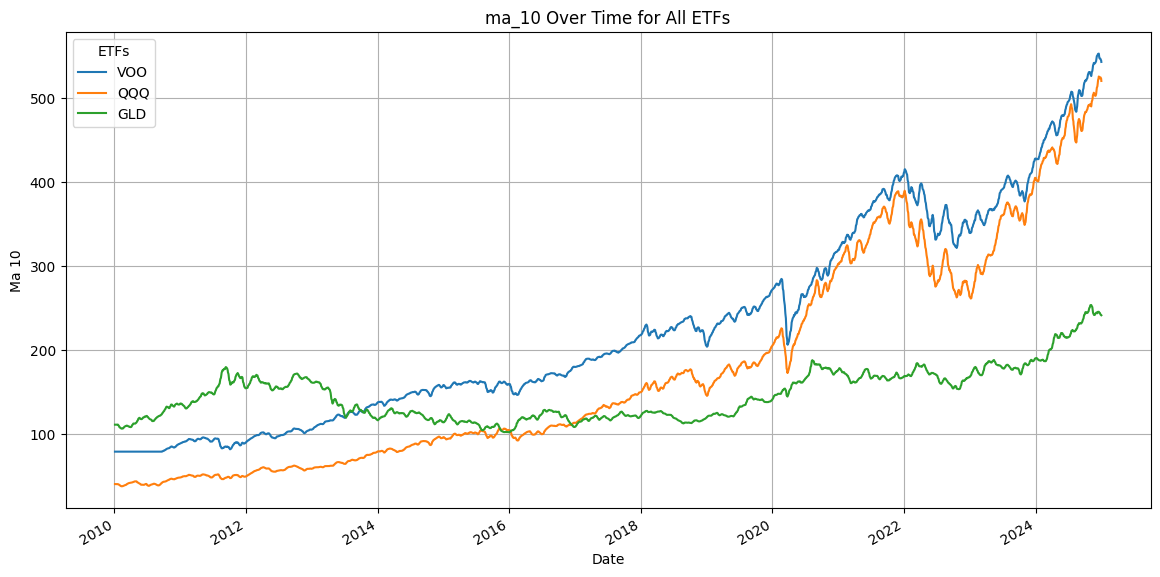

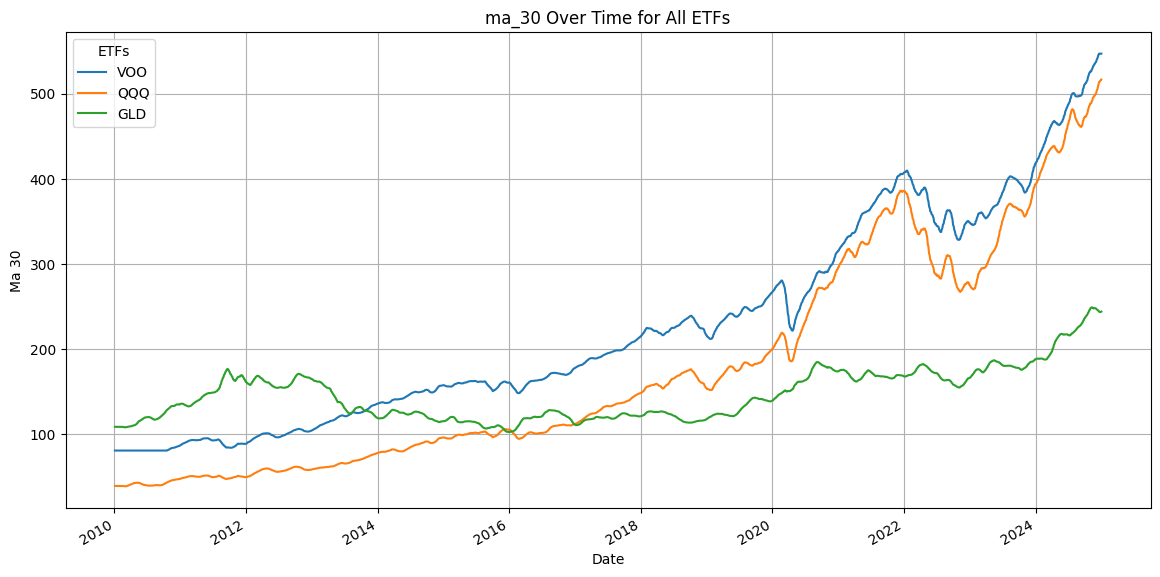

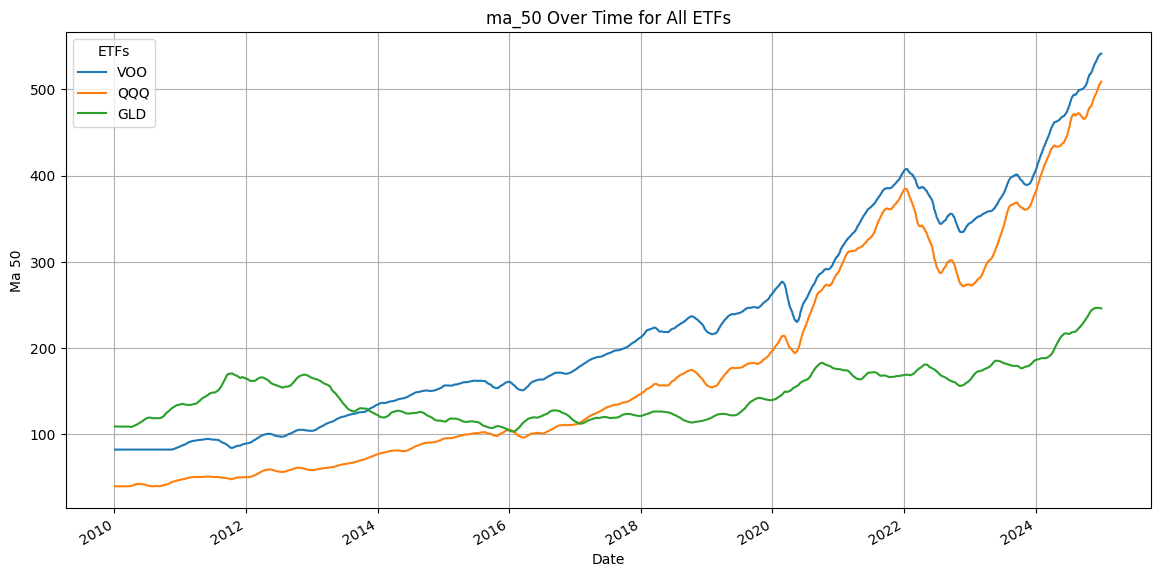

In [136]:
feature_names = data.columns.get_level_values(1).unique()

for feature_name in feature_names:
  # feature cross sections
  feature_data = data.xs(feature_name, level=1, axis=1)

  plt.figure(figsize=(14, 7))
  ax = plt.gca()

  feature_data.plot(ax=ax)

  plt.title(f'{feature_name} Over Time for All ETFs')
  plt.xlabel('Date')
  plt.ylabel(feature_name.replace('_', ' ').title())

  plt.legend(title='ETFs')

  plt.grid(True)
  plt.show()

Torch Dataset for our portfolio

In [137]:
class PortfolioDataset(Dataset):
  def __init__(self, df, lookback): # Corrected from init to __init__
    # days to lookback
    self.lookback = lookback

    # np array shape (days, n_tickers, n_features)
    self.data = df.values

    # returns cross section, and shift by 1 day, and then convert to np array
    self.returns = df.xs('return', level=1, axis=1).shift(-1).fillna(0).values
    self.length = len(self.data) - (lookback + 1)

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    # end of window
    offset = idx + self.lookback

    # feature shape = (lookback, total_features)
    x = self.data[idx : offset]

    # next day returns for every etf = (n_tickers,)
    y = self.returns[offset]
    return {
      'features': torch.tensor(x, dtype=torch.float),
      'returns':  torch.tensor(y, dtype=torch.float),
    }

Sinusoidal positional encoding for the transformer

In [138]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=500): # Corrected from init to __init__
    super().__init__()

    # vector of positional encoding = (max_len, d_model)
    positional_encoding_vec = torch.zeros(max_len, d_model)

    # vector of positions = (max_len, 1)
    position_vec = torch.arange(0, max_len).unsqueeze(1).float()

    # divisor term for each dimension
    div = torch.exp(
      torch.arange(0, d_model, 2).float() *
      (-np.log(10000.0) / d_model)
    )

    # sinusoidal encoding for even dimension
    positional_encoding_vec[:, 0::2] = torch.sin(position_vec * div)

    # cosine encoding for odd dimention
    positional_encoding_vec[:, 1::2] = torch.cos(position_vec * div)

    # positional_encoding is constant and not a parameter so not
    # updated by gradient
    self.register_buffer('positional_encoding', positional_encoding_vec.unsqueeze(0))

  def forward(self, x):
    return x + self.positional_encoding[:, :x.size(1), :]

Transormer Portfolio Model

In [143]:
class PortfolioTransformer(nn.Module):
  def __init__(self, seq_len, num_features, num_assets,
                d_model=128, nhead=8, num_layers=2, dim_ff=256, dropout=0.1, min_weight=1e-6): # Added min_weight
    super().__init__()

    # input layer
    self.input_layer = nn.Linear(num_features, d_model)

    # position encoding layer
    self.pos_enc_layer = PositionalEncoding(d_model, max_len=seq_len)

    # transformer encoder layer
    encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=dim_ff, dropout=dropout, activation='relu')

    # transormer encoder
    self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    # avg pool layer
    self.avg_pool_layer = nn.AdaptiveAvgPool1d(1)

    # output layer
    self.output_layer = nn.Linear(d_model, num_assets)

    self.min_weight = min_weight
    self.num_assets = num_assets

  def forward(self, x):
    # input
    x = self.input_layer(x)

    # encode position
    x = self.pos_enc_layer(x)
    x = x.permute(1, 0, 2)

    # transformer
    x = self.transformer_encoder(x)
    x = x.permute(1, 2, 0)

    # avg pool
    x = self.avg_pool_layer(x).squeeze(2)

    # output
    output = self.output_layer(x)

    # softmax
    weights = F.softmax(output, dim=1)


    # if self.min_weight > 0:
    #   scaling_factor = 1.0 - self.num_assets * self.min_weight
    #   valid_weights = self.min_weight + scaling_factor * softmax_weights
    # else:
    #   valid_weights = softmax_weights

    return weights

Sharpe loss

In [144]:
class SharpeLoss(nn.Module):
  def __init__(self):
    super().__init__()

    # to avoid div by 0
    self.eps = 1e-6

  def forward(self, weights, returns):
    # returns
    returns = (weights * returns).sum(dim=1)

    # mean returns
    mean_returns = returns.mean()

    # std of returns
    std_excess = returns.std(unbiased=False) + self.eps

    # sharpe ratio
    sharpe = mean_returns / std_excess

    # negative because we minimize loss
    return -sharpe

Training

In [147]:
# load data
dataset = PortfolioDataset(data, SAMPLE_DAYS)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# build model
model = PortfolioTransformer(
  seq_len=SAMPLE_DAYS,
  num_features=len(ETFS)*N_FEATURES,
  num_assets=len(ETFS),
  d_model=64,
  nhead=4,
  num_layers=2,
  dim_ff=128,
  dropout=0.1
).to(DEVICE)

# use neg sharpe as loss
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = SharpeLoss()

for epoch in range(1, 200):
  model.train()
  total = 0

  # batch train
  for batch_idx, batch in enumerate(data_loader):
    X = batch['features'].to(DEVICE)
    R = batch['returns'].to(DEVICE)

    # zero out
    opt.zero_grad()

    # forward pass to predict weights
    w = model(X)

    # printing loss
    if batch_idx == 0:
      print(f"  Epoch {epoch:02d}, Batch {batch_idx:03d} - Predicted Weights (first sample):")
      weights_to_print = w[0].detach().cpu().numpy()
      for i, etf in enumerate(ETFS):
        print(f"    {etf}: {weights_to_print[i]:.4f}", end=" ")
      print()

    # backprop
    loss = loss_fn(w, R)
    loss.backward()
    opt.step()
    total += loss.item()

  l = total / len(data_loader)
  print(f"Epoch {epoch:02d}, Loss: {l:.4f}")

  Epoch 01, Batch 000 - Predicted Weights (first sample):
    VOO: 0.3493     QQQ: 0.1791     GLD: 0.4716 
Epoch 01, Negative Sharpe Loss: -0.0755
  Epoch 02, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4264     QQQ: 0.2832     GLD: 0.2905 
Epoch 02, Negative Sharpe Loss: -0.0677
  Epoch 03, Batch 000 - Predicted Weights (first sample):
    VOO: 0.3957     QQQ: 0.2632     GLD: 0.3410 
Epoch 03, Negative Sharpe Loss: -0.0665
  Epoch 04, Batch 000 - Predicted Weights (first sample):
    VOO: 0.3889     QQQ: 0.2758     GLD: 0.3354 
Epoch 04, Negative Sharpe Loss: -0.0656
  Epoch 05, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4453     QQQ: 0.2334     GLD: 0.3214 
Epoch 05, Negative Sharpe Loss: -0.0763
  Epoch 06, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4570     QQQ: 0.2822     GLD: 0.2609 
Epoch 06, Negative Sharpe Loss: -0.0720
  Epoch 07, Batch 000 - Predicted Weights (first sample):
    VOO: 0.4030     QQQ: 0.3657     GLD: 0.2313 
Epoch 07, N

Plots

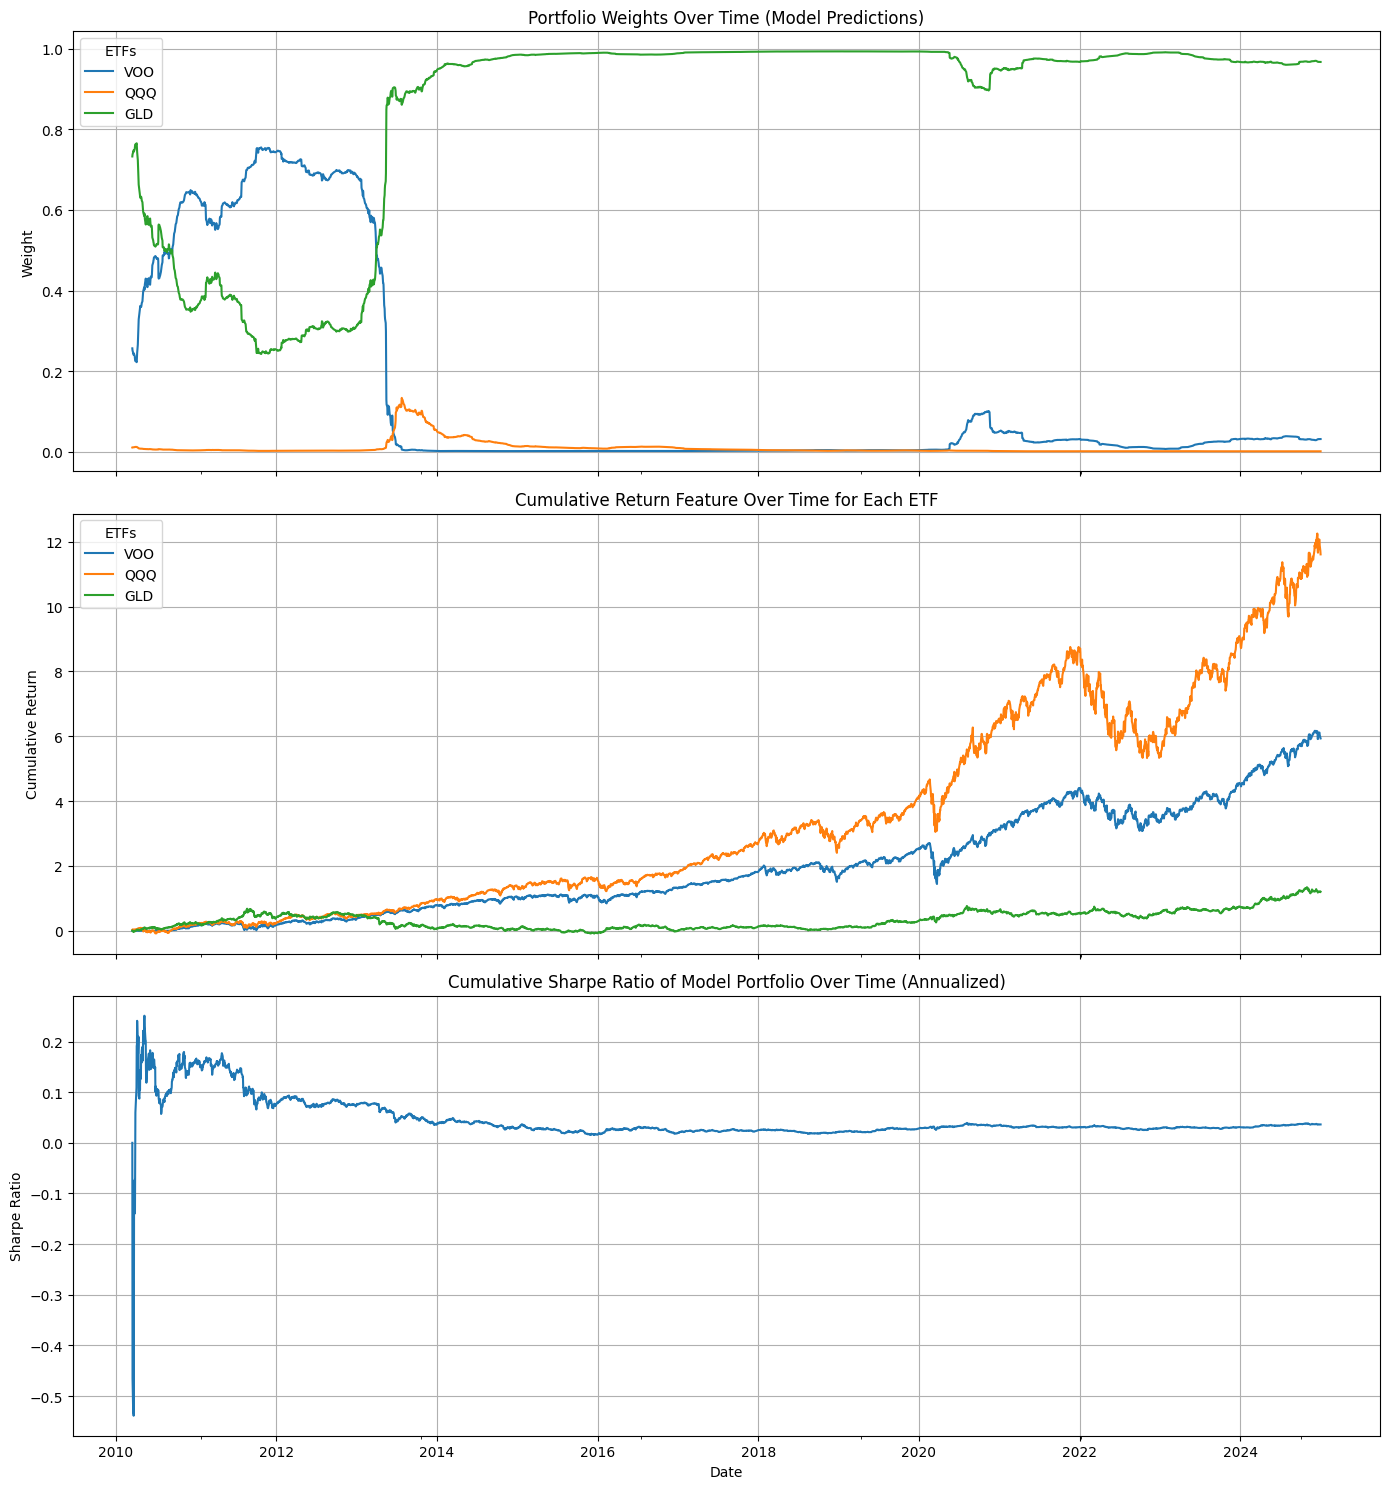

In [150]:
# eval mode
model.eval()
predicted_weights = []
actual_returns = []
portfolio_returns = []
dates = []
all_dates = data.index[(SAMPLE_DAYS + 1):]

# zero grad for prediciton
with torch.no_grad():
  for i in range(len(dataset)):

    # single sample
    batch = dataset[i]
    X = batch['features'].unsqueeze(0).to(DEVICE)
    R_actual = batch['returns'].cpu().numpy()

    # portfolio weights
    weights = model(X).squeeze(0).cpu().numpy()

    # store weights, returns, dates
    predicted_weights.append(weights)
    actual_returns.append(R_actual)
    dates.append(all_dates[i])

    # portfolio return: dot product of weights and actual returns
    Rp_t = np.sum(weights * R_actual)
    portfolio_returns.append(Rp_t)

# to np
predicted_weights = np.array(predicted_weights)
actual_returns = np.array(actual_returns)
portfolio_returns = np.array(portfolio_returns)

# compound return
compounded_returns = (1 + portfolio_returns).cumprod()

cumulative_sharpe_ratios = []
for j in range(len(portfolio_returns)):
  returns_subset = portfolio_returns[:j+1]

  if len(returns_subset) > 1:
    mean_return = np.mean(returns_subset)
    std_return = np.std(returns_subset, ddof=0)

    if std_return != 0:
      # sharpe ratio no risk free
      sharpe = (mean_return / std_return)
    else:
      sharpe = 0
    cumulative_sharpe_ratios.append(sharpe)
  else:
    cumulative_sharpe_ratios.append(0)

cumulative_sharpe_ratios = np.array(cumulative_sharpe_ratios)

# feature cross section
cumulative_return_feature_data_for_plot = data.loc[dates].xs('cumulative_return', level=1, axis=1)

fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

# weights vs time
axes[0].set_title('Portfolio Weights Over Time (Model Predictions)')
axes[0].set_ylabel('Weight')
for i, etf in enumerate(ETFS):
  axes[0].plot(dates, predicted_weights[:, i], label=etf)
axes[0].legend(title='ETFs')
axes[0].grid(True)

# return vs time
axes[1].set_title('Cumulative Return Feature Over Time for Each ETF')
axes[1].set_ylabel('Cumulative Return')
cumulative_return_feature_data_for_plot.plot(ax=axes[1])
axes[1].legend(title='ETFs')
axes[1].grid(True)

# shapre vs time
axes[2].set_title('Cumulative Sharpe Ratio of Model Portfolio Over Time (Annualized)')
axes[2].set_ylabel('Sharpe Ratio')
axes[2].set_xlabel('Date')
axes[2].plot(dates, cumulative_sharpe_ratios)
axes[2].grid(True)


plt.tight_layout()
plt.show()